In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

full_df = pd.read_csv('ed2017_sas.csv',low_memory=False)
full_df = full_df.fillna(value=-1)
full_df.head()

,VMONTH,VDAYR,ARRTIME,WAITTIME,BLANK1,AGE,AGER,AGEDAYS,RESIDNCE,SEX,...,RX30V3C1,RX30V3C2,RX30V3C3,RX30V3C4,SETTYPE,YEAR,CSTRATM,CPSUM,PATWT,EDWT
0,6,6,2056,72,-1.0,27,3,-7,1,2,...,-1.0,-1.0,-1.0,-1.0,3,2017,40100000,4,3723.12641,21.58043
1,6,2,1417,64,-1.0,1,1,-7,1,1,...,-1.0,-1.0,-1.0,-1.0,3,2017,40100000,4,3723.12641,-1.00000
2,6,2,2303,-7,-1.0,52,4,-7,1,2,...,-1.0,-1.0,-1.0,-1.0,3,2017,40100000,4,3723.12641,-1.00000
3,6,5,930,29,-1.0,5,1,-7,1,2,...,-1.0,-1.0,-1.0,-1.0,3,2017,40100000,4,3723.12641,-1.00000
4,6,2,1332,20,-1.0,4,1,-7,1,1,...,-1.0,-1.0,-1.0,-1.0,3,2017,40100000,4,3723.12641,-1.00000


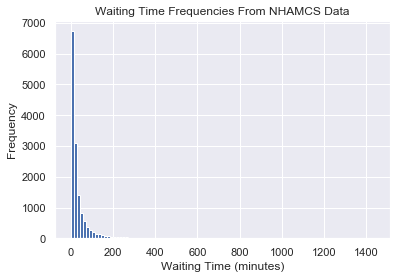

Accuracy for majority class model: 0.17321739130434782


In [156]:
## PREPROCESSING ##

from sklearn.model_selection import train_test_split

# take a subset of the dataframe - could potentially drop AGER as well (which is age for people under 1 years)
#subset_df = full_df.iloc[:,list(range(36)) + list(range(41,46)) + list(range(60,81))].drop(columns=["BLANK1"]) # this one large
subset_df = full_df.iloc[:,:36].drop(columns=["BLANK1"])

# for now remove negative values -9 and -7 from WAITTIME
subset_df = subset_df[subset_df["WAITTIME"] != -9]
subset_df = subset_df[subset_df["WAITTIME"] != -7]

# set all negative values in the dataframe to the median of the attribute - this is probably not a great way of 
# processing the data, so may need to change later on.
subset_df[subset_df<0] = subset_df[subset_df<0].apply(lambda x: x*subset_df[subset_df>0][x.name].median()/x)

# Discretise numeric attributes into bins (helps to reduce noise in data)
mod_df = subset_df.apply(lambda x: (x/100).astype(int)*100+30 if x.name in ["ARRTIME"] else x) # '+30' as using minutes
mod_df = subset_df.apply(lambda x: (x/5).astype(int)*5 if x.name in ["WAITTIME"] else x)
cols = ["AGE","TEMPF","PULSE","BPSYS","BPDIAS"]
mod_df = mod_df.apply(lambda x: (x/3).astype(int)*3+1.5 if x.name in cols else x)

# set all negative values in dataframe to mode of the class??
# mod_df.groupby("WAITTIME").mean()

# change data so that all independent variables are binary (0 and 1)
final_df = pd.get_dummies(mod_df, columns=list(mod_df.drop(columns="WAITTIME")))

# Splitting the data into test and training sets
X = final_df.iloc[:,1:].values
y = final_df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# we have an unbalanced dataset, need to look at confusion matrices later
plt.hist(final_df["WAITTIME"],bins=100)
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Waiting Time Frequencies From NHAMCS Data')
plt.show()

unique, counts = np.unique(y_test, return_counts = True)
print("Accuracy for majority class model: " + str(counts[0]/sum(counts)))

              precision    recall  f1-score   support

           0       0.19      0.50      0.28       498
           5       0.17      0.40      0.24       487
          10       0.16      0.15      0.15       361
          15       0.09      0.01      0.03       268
          20       0.00      0.00      0.00       189
          25       0.00      0.00      0.00       147
          30       0.00      0.00      0.00       124
          35       0.00      0.00      0.00        99
          40       0.00      0.00      0.00        75
          45       0.00      0.00      0.00        51
          50       0.00      0.00      0.00        61
          55       0.00      0.00      0.00        54
          60       0.00      0.00      0.00        46
          65       0.00      0.00      0.00        27
          70       0.00      0.00      0.00        20
          75       0.00      0.00      0.00        30
          80       0.00      0.00      0.00        23
          85       0.00    

Text(73.7, 0.5, 'Actual Times')

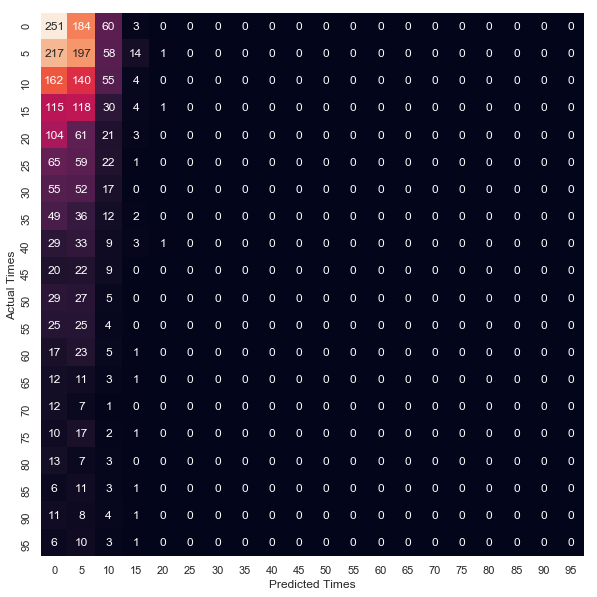

In [154]:
## RANDOM FOREST ##

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Normalise data through feature scaling to increase speed
scaler = StandardScaler()
X_trainRF = scaler.fit_transform(X_train)
X_testRF = scaler.transform(X_test)

# note more trees seems to lead to better accuracy until certain point (10->0.16, 100->0.18, 500->0.19)
# criterion does not lead to noticeable change in accuracy
# balanced class weights has no noticeable effect on accuracy for 10 trees but better for 100 and 500 trees
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 4, class_weight = 'balanced')
classifier.fit(X_trainRF, y_train)

# Predicting the Test set results and evaluating results
y_predRF = classifier.predict(X_test)
print(classification_report(y_test,y_predRF,zero_division=0))

# for full confusion matrix
#cm = pd.crosstab(y_test, y_pred, rownames=['Actual Times'], colnames=['Predicted Times'])
#print(cm)

# 20 by 20 confusion matrix (more visual, submatrix of confusion matrix)
mat = confusion_matrix(y_predRF, y_test)
submat = mat[:20,:20]
subx_ypredRF = list(set(y_predRF))
suby_ytest = list(set(y_test))
subx_ypredRF.sort()
suby_ytest.sort()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(submat.T, square=True, annot=True, fmt='d', cbar=False,xticklabels=suby_ytest[:20], yticklabels=suby_ytest[:20], ax=ax)
plt.xlabel('Predicted Times')
plt.ylabel('Actual Times')

              precision    recall  f1-score   support

           0       0.20      0.47      0.29       498
           5       0.18      0.33      0.23       487
          10       0.13      0.21      0.16       361
          15       0.08      0.05      0.06       268
          20       0.12      0.03      0.04       189
          25       0.00      0.00      0.00       147
          30       0.00      0.00      0.00       124
          35       0.00      0.00      0.00        99
          40       0.00      0.00      0.00        75
          45       0.00      0.00      0.00        51
          50       0.00      0.00      0.00        61
          55       0.00      0.00      0.00        54
          60       0.00      0.00      0.00        46
          65       0.00      0.00      0.00        27
          70       0.00      0.00      0.00        20
          75       0.00      0.00      0.00        30
          80       0.00      0.00      0.00        23
          85       0.00    

Text(73.7, 0.5, 'Actual Times')

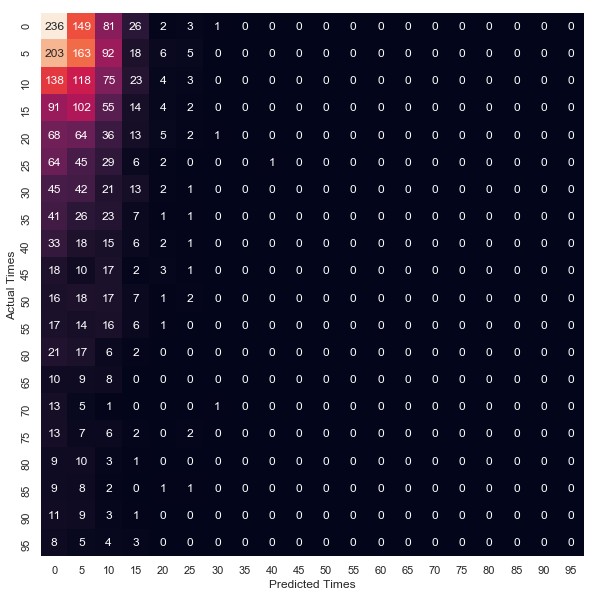

In [147]:
## NAIVE BAYES ##

from sklearn.naive_bayes import MultinomialNB

# need to fix imbalanced data - could use frequency count thing

model = MultinomialNB() # default has Laplace smoothing
model.fit(X_train,y_train)
y_predNB = model.predict(X_test)
print(classification_report(y_test,y_predNB,zero_division=0))

mat2 = confusion_matrix(y_predNB, y_test)
submat2 = mat2[:20,:20]
subx_ypredNB = list(set(y_predNB))
subx_ypredNB.sort()
fig2, ax2 = plt.subplots(figsize=(10,10))
sns.heatmap(submat2.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=suby_ytest[:20], yticklabels=suby_ytest[:20], ax=ax2)
plt.xlabel('Predicted Times')
plt.ylabel('Actual Times')

In [157]:
## NEURAL NETS ##
